# Import, preparing


In [7]:
!pip install tika pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 8.2 MB 34.4 MB/s 
  Created wheel for tika: filename=tika-1.24-py3-none-any.whl size=32892 sha256=fe03d518917fb50e44cde85e11beb8017b597ee1666e82b50bf83d33560beaa8
  Stored in directory: /root/.cache/pip/wheels/75/66/8b/d1acbac7d49f3d98ade76c51ae5d72cec1866131a3b1ad9f82
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=34925f6b43740341399fe335723ba8fb5c1bac63c3edd5c3339a163d8d28c7b0
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built tika docopt


In [8]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import string
from tqdm.notebook import tqdm
import matplotlib
from sklearn.metrics import classification_report

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pymorphy2

from sklearn.decomposition import TruncatedSVD
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import tika
from tika import parser
import re
import os
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
classes = pd.read_json('/content/drive/MyDrive/X_MAS_hack_документы/classes.json', orient='index')

In [10]:
classes.head(2)

,0
5908cb5da047d6c9e6dfea6337fb3189.doc,Договоры для акселератора/Договоры поставки
14711e4fc8e56f0c75856c8837ec04cb.doc,Договоры для акселератора/Договоры поставки


In [11]:
list_docs = os.listdir('/content/drive/MyDrive/X_MAS_hack_документы/docs')

In [12]:
tika.initVM()

for doc in tqdm(list_docs):
  parsed = parser.from_file('/content/drive/MyDrive/X_MAS_hack_документы/docs/' + doc)
  # classes.loc[doc, 'metadata'] = parsed["metadata"]
  classes.loc[doc, 'content'] = parsed["content"]

  0%|          | 0/120 [00:00<?, ?it/s]

2022-12-16 18:28:40,826 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
INFO:tika.tika:Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
2022-12-16 18:28:41,493 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
INFO:tika.tika:Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
2022-12-16 18:28:41,911 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...
2022-12-16 18:28:46,922 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


# Logreg

In [13]:
%%time
stop_words = set(stopwords.words('russian')) # множество стоп слов

morph = pymorphy2.MorphAnalyzer() # для постановки слова в начальную форму

def lemmatize_words(text):
    '''Функция для лемматизации отдельных слов.'''
    final_text = []
    for i in text.lower().split():
        if i not in stop_words:
            parse = morph.parse(i)[0]
            if ('Abbr' not in parse.tag):
                final_text.append(parse.normal_form)               
    return " ".join(final_text)

def text_preprocessing(text):
    data = text.copy()

    # удаляем пунктуацию
    data['content_punct'] = data['content'].str.translate(str.maketrans('', '', string.punctuation))
    # Приводим к начальной форме
    data['content_punct_lemm'] = data['content_punct'].apply(lemmatize_words)
    
    return data

classes_prep = text_preprocessing(classes)

# test_copy = test.copy()
# test_copy.rename(columns={'text': 'sentence'}, inplace=True)
# test_prep = text_preprocessing(test_copy.fillna('нет текста'))

CPU times: user 37.3 s, sys: 142 ms, total: 37.5 s
Wall time: 39.2 s


In [14]:
classes_prep = text_preprocessing(classes)

In [15]:
le = LabelEncoder()
classes_prep['labels'] = le.fit_transform(classes_prep[0])

In [16]:
classes_prep[0].value_counts()

Договоры для акселератора/Договоры оказания услуг    32
Договоры для акселератора/Договоры аренды            23
Договоры для акселератора/Договоры купли-продажи     23
Договоры для акселератора/Договоры поставки          21
Договоры для акселератора/Договоры подряда           21
Name: 0, dtype: int64

In [17]:
def plot_LSA(test_data, test_labels):
    '''
    Функция для уменьшения размерности и визуализации векторного представления текстов по классам в проекции на плоскость
    '''
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    colors = ['orange','blue','blue']
    plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=0.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color='orange', label='0')
    green_patch = mpatches.Patch(color='blue', label='1')
    plt.legend(handles=[red_patch, green_patch], prop={'size': 12})
    plt.title('Визуализация векторного представления текстов в проекции на плоскость', fontsize=14)

def plot_feature_importance(importance, names, model_name, numb_of_features=10):
    '''
    Для построения важности признаков
    '''
    # DataFrame из важности признаков модели с именами столбцов
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # Сортируем по убыванию
    fi_df_sort = fi_df.sort_values(by=['feature_importance'], ascending=False)
    
    # Строим график
    if model_name == 'LogisticRegression':
        fig,ax = plt.subplots(2,1, figsize=(10,16))
        sns.barplot(x='feature_importance', y='feature_names', data=fi_df_sort[:numb_of_features], ax=ax[0])
        sns.barplot(x='feature_importance', y='feature_names', data=fi_df_sort[-numb_of_features:],ax=ax[1])
    else:
        fig,ax = plt.subplots(1,1, figsize=(10,8))
        sns.barplot(x='feature_importance', y='feature_names', data=fi_df_sort[:numb_of_features])
        
    plt.title(model_name + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()
    

def learning(X_train, X_test, y_train, y_test, classifier, name_of_classifier, plot_lsa=False,
             ngram_range_user=(1,1), numb_of_features_user=10):
    '''
    Обучение модели. Возвращаем TfidfVectorizer для теста и обученный классификатор
    '''
    
    tf=TfidfVectorizer(ngram_range=ngram_range_user)
    X_train_tf = tf.fit_transform(X_train)
    X_test_tf = tf.transform(X_test)
    if plot_lsa == True:
        fig = plt.figure(figsize=(10, 8)) 
        plot_LSA(X_train_tf, y_train)
        plt.show()
    
    classifier.fit(X_train_tf, y_train)
    classifier_pred = classifier.predict(X_test_tf)
    classifier_pred_proba = classifier.predict_proba(X_test_tf)
    
    # print('{} confusion_matrix: \n'.format(name_of_classifier), confusion_matrix(y_test, classifier_pred))
    print('{} classification_report: \n'.format(name_of_classifier), classification_report(y_test, classifier_pred))
    # print('{} roc_auc: '.format(name_of_classifier), roc_auc_score(y_test, classifier_pred_proba, multi_class="ovr"))
    
    if name_of_classifier == 'LogisticRegression':
        plot_feature_importance(classifier.coef_[0],
                                list(tf.vocabulary_.keys()), name_of_classifier, numb_of_features=numb_of_features_user)
    else:
        plot_feature_importance(classifier.feature_importances_,
                                list(tf.vocabulary_.keys()), name_of_classifier, numb_of_features=numb_of_features_user)
        
    return tf, classifier

In [18]:
# Делим на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(classes_prep['content_punct_lemm'],
                                                    classes_prep['labels'],
                                                    test_size=0.2, random_state=42,
                                                    stratify=classes_prep['labels'])

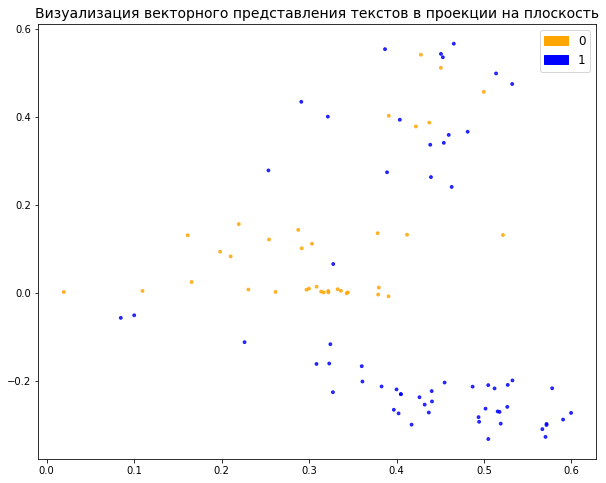

LogisticRegression classification_report: 
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       0.86      1.00      0.92         6
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4

    accuracy                           0.96        24
   macro avg       0.97      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



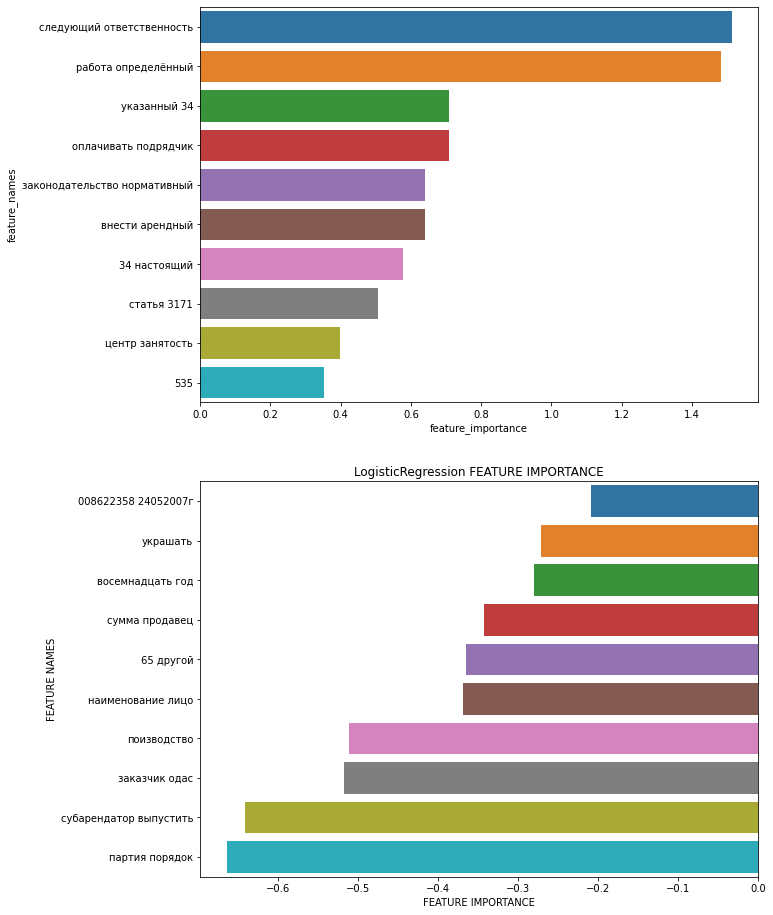

CPU times: user 3.44 s, sys: 1.71 s, total: 5.15 s
Wall time: 3.75 s


In [19]:
%%time
LR = LogisticRegression(random_state=42)
tf, LR_trained_classifier = learning(X_train, X_test, y_train, y_test, LR,
                                     'LogisticRegression', ngram_range_user=(1,2), plot_lsa=True)

# RoBERTa

## Upload

In [13]:
!pip install regex requests hydra-core omegaconf bitarray sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 153 kB 5.0 MB/s 
     |████████████████████████████████| 79 kB 8.5 MB/s 
     |████████████████████████████████| 241 kB 50.7 MB/s 
     |████████████████████████████████| 118 kB 67.4 MB/s 
     |████████████████████████████████| 117 kB 59.5 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=cbc022ee8ad92038aab55eb3e79f57a286e20229bd1bb7b2e4ec1c1ab667f331
  Stored in directory: /root/.cache/pip/wheels/b1/a3/c2/6df046c09459b73cc9bb6c4401b0be6c47048baf9a1617c485
Successfully built antlr4-python3-runtime


In [14]:
%%time
import torch
roberta = torch.hub.load('pytorch/fairseq', 'roberta.large')
roberta.eval()

Downloading: "https://github.com/pytorch/fairseq/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


running build_ext
cythoning fairseq/data/data_utils_fast.pyx to fairseq/data/data_utils_fast.cpp


/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py:476: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))


cythoning fairseq/data/token_block_utils_fast.pyx to fairseq/data/token_block_utils_fast.cpp
building 'fairseq.libbleu' extension
creating build
creating build/temp.linux-x86_64-3.8
creating build/temp.linux-x86_64-3.8/fairseq
creating build/temp.linux-x86_64-3.8/fairseq/clib
creating build/temp.linux-x86_64-3.8/fairseq/clib/libbleu
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.8 -c fairseq/clib/libbleu/libbleu.cpp -o build/temp.linux-x86_64-3.8/fairseq/clib/libbleu/libbleu.o -std=c++11 -O3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE="_gcc" -DPYBIND11_STDLIB="_libstdcpp" -DPYBIND11_BUILD_ABI="_cxxabi1011" -DTORCH_EXTENSION_NAME=libbleu -D_GLIBCXX_USE_CXX11_ABI=0
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEB

100%|██████████| 655283069/655283069 [00:11<00:00, 56324099.92B/s]
/usr/local/lib/python3.8/dist-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/usr/local/lib/python3.8/dist-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/usr/local/lib/python3.8/dist-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)
/usr/local/lib/python3.8/dist-packages/hydra/core/default_element.py:124: UserWarning: In 'config': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/changes_to_package_header for more informa

CPU times: user 42.4 s, sys: 6.08 s, total: 48.4 s
Wall time: 3min


RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(50265, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0): TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dr

## work

In [3]:
tokens = roberta.encode('Hello world!')
assert tokens.tolist() == [0, 31414, 232, 328, 2]
assert roberta.decode(tokens) == 'Hello world!'

In [5]:
# Extract the last layer's features
last_layer_features = roberta.extract_features(tokens)
assert last_layer_features.size() == torch.Size([1, 5, 1024])

# Extract all layer's features (layer 0 is the embedding layer)
all_layers = roberta.extract_features(tokens, return_all_hiddens=True)
assert len(all_layers) == 25
assert torch.all(all_layers[-1] == last_layer_features)

In [20]:
%%time
classes_prep['roberta'] = classes_prep['content_punct_lemm'].apply(roberta.encode)

CPU times: user 7.28 s, sys: 33.2 ms, total: 7.31 s
Wall time: 7.49 s


### Using RoBERTA for text classification

https://jesusleal.io/2020/10/20/RoBERTA-Text-Classification/

https://github.com/jlealtru/website_tutorials/blob/main/notebooks/RoBERTA%20with%20IMDB.ipynb

In [1]:
!pip install transformers wandb datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.2 MB/s 
     |████████████████████████████████| 1.9 MB 40.9 MB/s 
     |████████████████████████████████| 451 kB 48.5 MB/s 
     |████████████████████████████████| 7.6 MB 41.9 MB/s 
     |████████████████████████████████| 182 kB 8.2 MB/s 
     |████████████████████████████████| 173 kB 45.0 MB/s 
     |████████████████████████████████| 182 kB 6.0 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 168 kB 49.5 MB/s 
     |████████████████████████████████| 168 kB 72.4 MB/s 
     |████████████████████████████████| 166 kB 47.5 MB/s 
     |████████████████████████████████| 166 kB 37.3 MB/s 
     |████████████████████████████████| 162 kB 77.3 MB/s 
     |████████████████████████████████| 162 kB 50.7 MB/s 
     |████████████████████████████████| 158 kB 63.6 MB/s 
     |██████████████████████████████

In [2]:
import pandas as pd
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification,Trainer, TrainingArguments
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import wandb
import os

import datasets

In [3]:
%%time
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length = 512)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

CPU times: user 14.3 s, sys: 3.16 s, total: 17.5 s
Wall time: 38.5 s


In [4]:
# define accuracy metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [5]:
# define the training arguments
training_args = TrainingArguments(
    output_dir = '/media/data_files/github/website_tutorials/results',
    num_train_epochs=2,
    per_device_train_batch_size = 16,
    gradient_accumulation_steps = 16,    
    per_device_eval_batch_size= 8,
    # evaluation_strategy = "epoch",
    evaluation_strategy = "steps",
    disable_tqdm = False, 
    load_best_model_at_end=True,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps = 5,
    # fp16 = True,
    logging_dir='/media/data_files/github/website_tutorials/logs',
    dataloader_num_workers = 0,
    run_name = 'roberta-classification_titan',
    remove_unused_columns=False
)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [20]:
X_train, X_test = train_test_split(classes_prep[['content_punct_lemm', 'labels']],
                                                    test_size=0.2, random_state=42,
                                                    stratify=classes_prep['labels'])

In [21]:
def tokenization(batched_text):
    return tokenizer(batched_text['content_punct_lemm'], padding = True, truncation=True)


train_dataset = datasets.Dataset.from_pandas(pd.DataFrame(X_train))
test_dataset = datasets.Dataset.from_pandas(pd.DataFrame(X_test))

train_data = train_dataset.map(tokenization, batched = True, batch_size = len(train_dataset))
test_data = test_dataset.map(tokenization, batched = True, batch_size = len(test_dataset))

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [22]:
train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_data.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [23]:
# instantiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=test_data,
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
# train the model
trainer.train()

In [31]:
trainer.evaluate()


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 8


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
5,1.205600,1.210345,0.500000,0.000000,0.000000,0.000000
10,1.213800,1.172456,0.500000,0.000000,0.000000,0.000000
15,1.187600,1.100657,0.500000,0.000000,0.000000,0.000000
20,0.958600,1.029176,0.500000,0.000000,0.000000,0.000000
25,0.996300,0.949155,0.500000,0.000000,0.000000,0.000000
30,0.892200,0.853193,0.500000,0.000000,0.000000,0.000000
35,0.816100,0.775234,0.500000,0.000000,0.000000,0.000000
40,0.754900,0.722157,0.500000,0.000000,0.000000,0.000000
45,0.700400,0.697762,0.500000,0.000000,0.000000,0.000000
50,0.700500,0.689908,0.504480,0.024567,0.780000,0.012480


{'eval_loss': 0.3603783845901489,
 'eval_accuracy': 0.8766,
 'eval_f1': 0.887297702115223,
 'eval_precision': 0.8165131446244873,
 'eval_recall': 0.97152}